In [1]:
from math import e, log
import matplotlib.pyplot as plt
import numpy as np
import torch

### Entropy
+ Ask how many binary question to know exact class. E = sum( -p*log(p) )

D1 = [0.25, 0.25, 0.25, 0.25] -> E1 = -0.25\*log(0.25) -0.25\*log(0.25) -0.25\*log(0.25) -0.25\*log(0.25) = 2

D2 = [0.5, 0.25, 0.25, 0] -> E2 = -0.5\*log(0.5) -0.25\*log(0.25) -0.25\*log(0.25) -0\*log(0) = 1.5

### Cross entropy
+ entropy of binary classification
    + D = [p, 1-p] -> E = p*log(p) + (1-p)*log(1-p) <br><br>

+ cross entropy: distribution difference
    + CE = sum(plogq) <br><br>
    
+ cross entropy of binary classification:
    + D1 = [p, 1-p], D2 = [p+e, 1-p-e]
    + f = p\*log(p+e) + (1-p)\*log(1-p-e)
    + argmin_e f = 0 -> e=0 <br><br>

+ Why not using MSE
    + the last activation e.g. sigmoid or softmax
        + activation(x=inf)=1, x must as large as possible 
        + activation(x=-inf)=0, x must as small as possible
    + mse let x become 0 or 1

### Visualization of MSE, CE, Focal loss

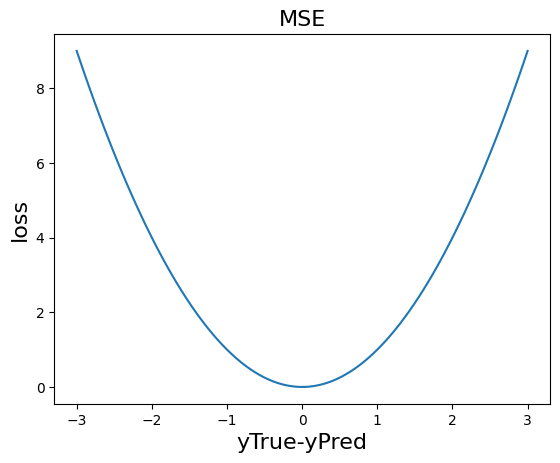

In [3]:
# mse = (yTrue-yPred)^2
deltaY = np.linspace(-3,3,100)
loss = deltaY**2 
plt.plot(deltaY, loss)
plt.title("MSE", fontsize=16)
plt.xlabel("yTrue-yPred", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.show()

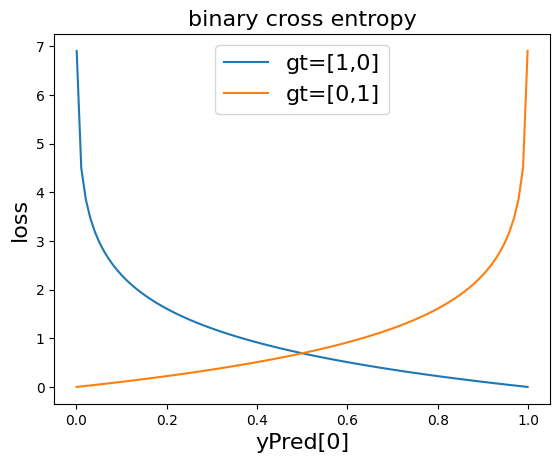

In [4]:
# bce = -log(yPred[0]) if yTrue=[1,0] else -log(1-yPred[0])
eps=1e-3
predY = np.linspace(eps,1-eps,100)
lossGTC0 = -1*np.log(predY)
lossGTC1 = -1*np.log(1-predY)
plt.plot(predY,lossGTC0)
plt.plot(predY,lossGTC1)
plt.title("binary cross entropy", fontsize=16)
plt.xlabel("yPred[0]", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.legend(labels=["gt=[1,0]", "gt=[0,1]"], fontsize=16)
plt.show()

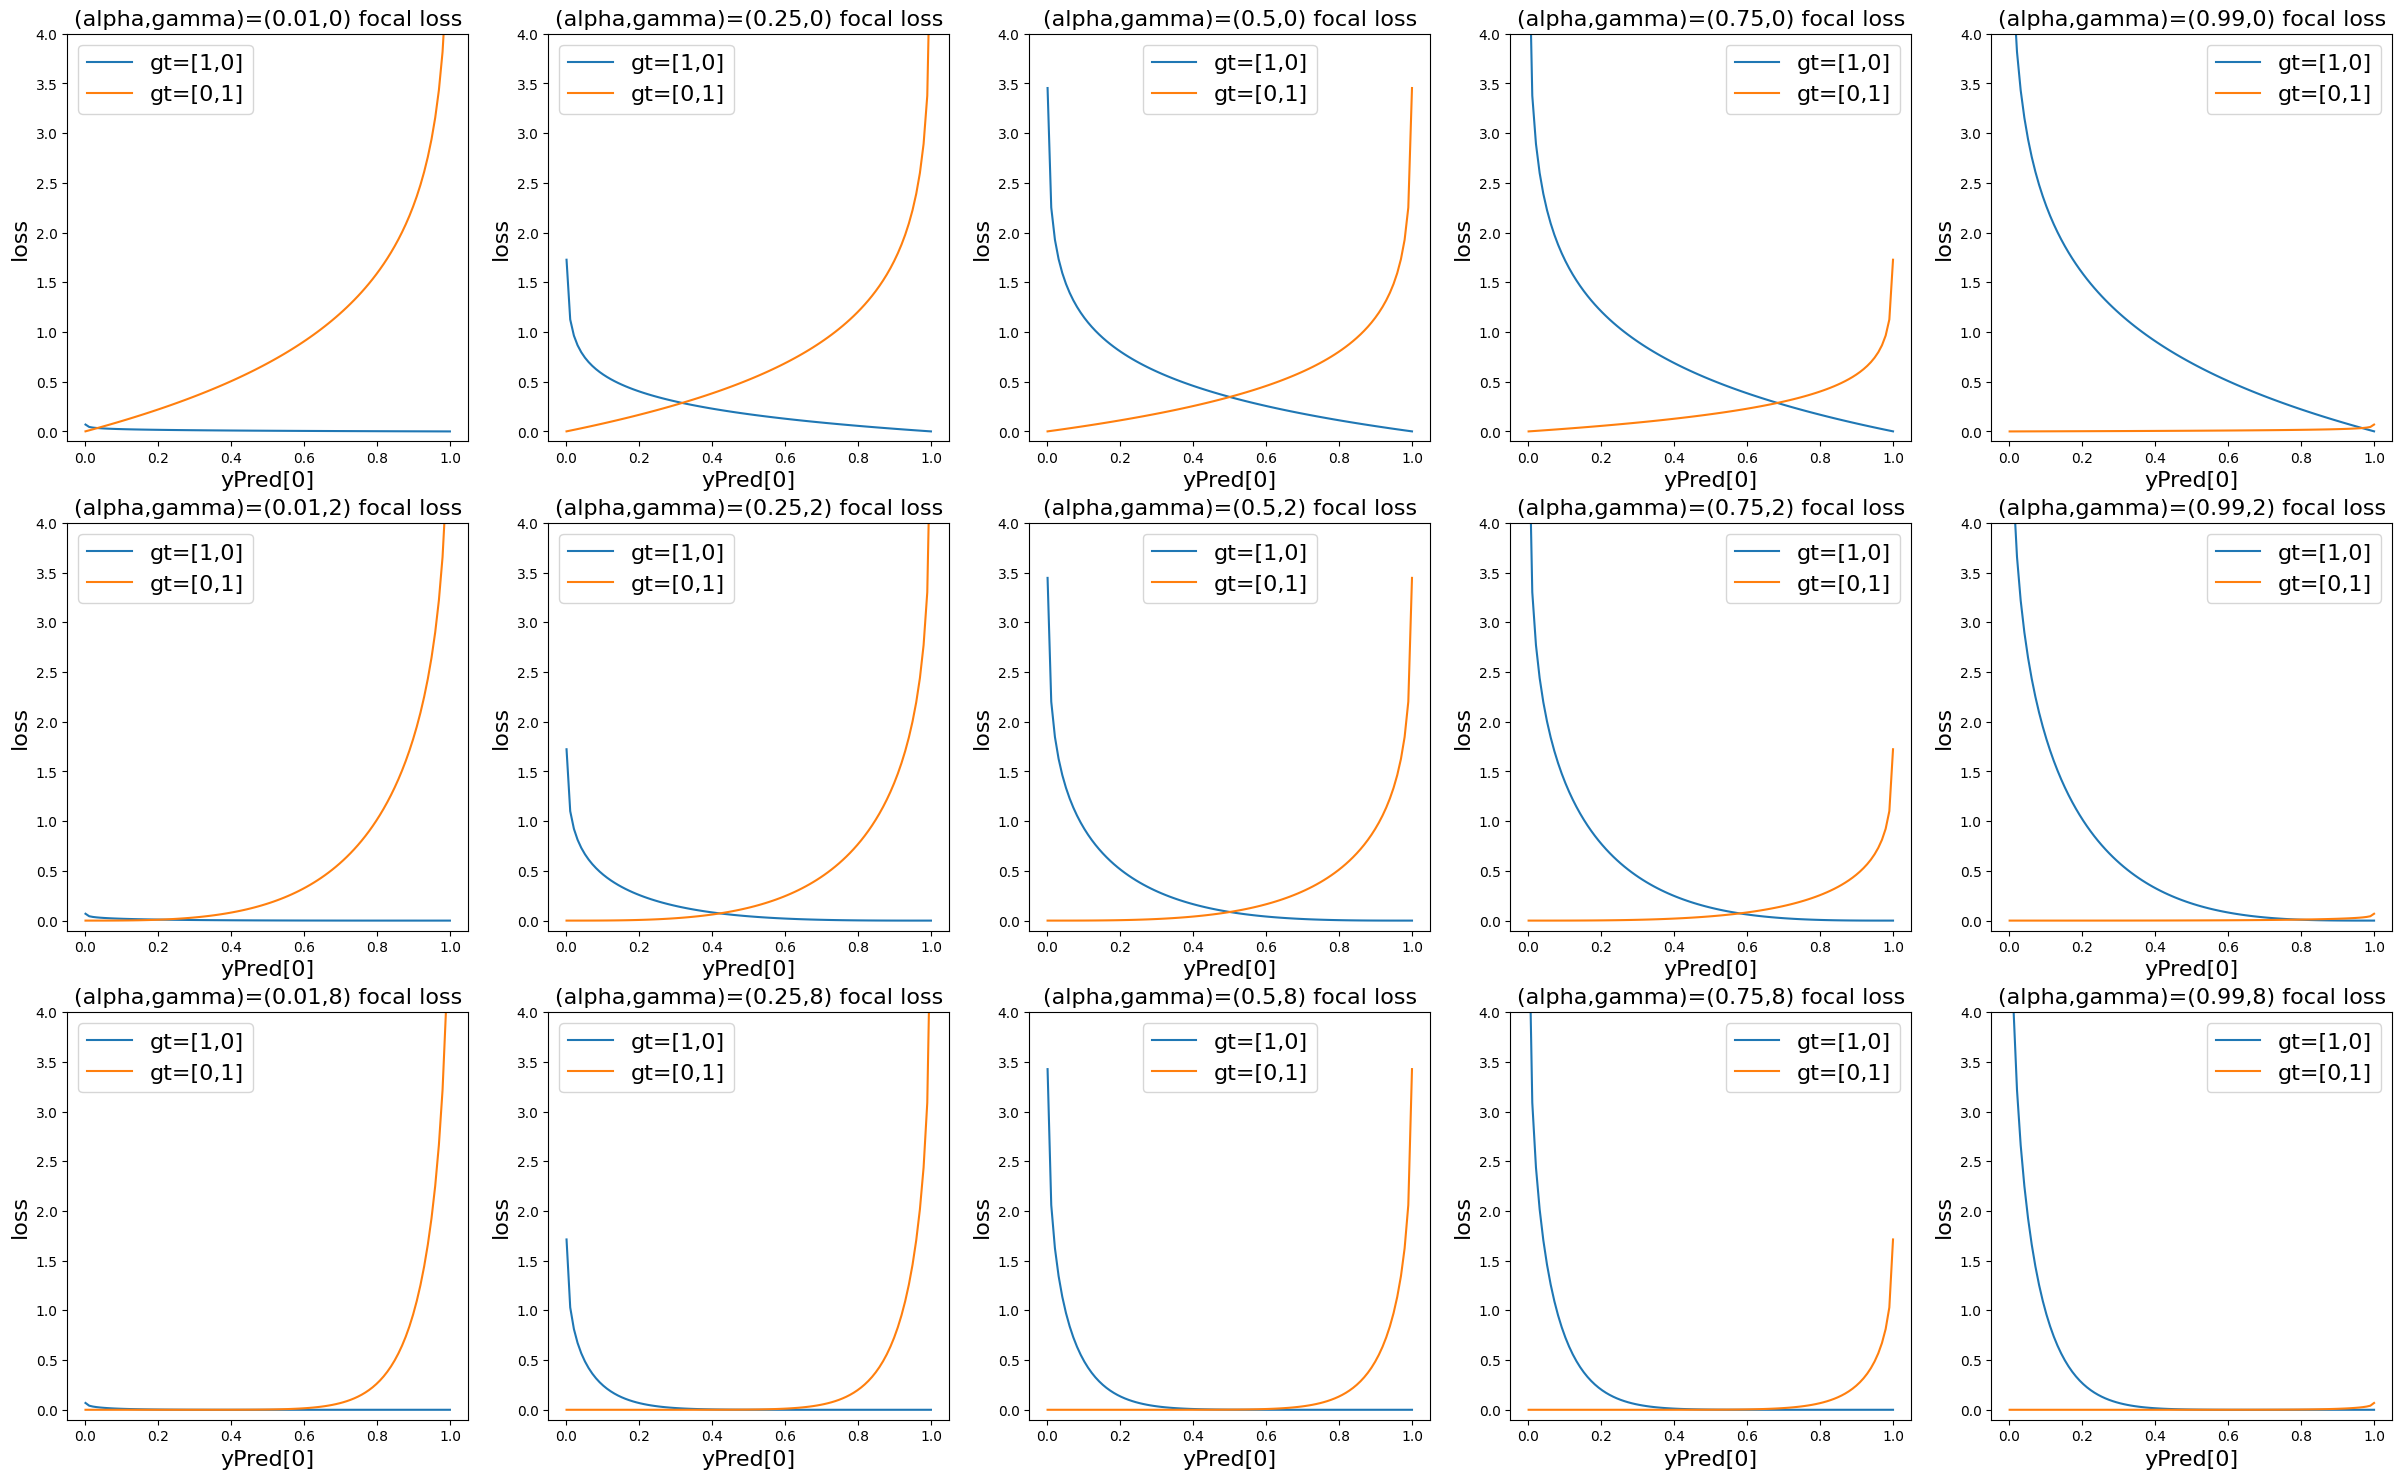

In [5]:
# FP:upper left, FN:upper right, TN:down left, TP:down right
# precision=TP/(FP+TP), recall=TP/(FN+TP)
# if value at precision: loss(FN)>loss(FP), i.e. 0<alpha<0.5
# loss near TN -> 0
# focal_loss = -alpha*(1-yPred[0])**gamma*log(yPred[0]) if yTrue=[1,0] else -(1-alpha)*yPred[0]**gamma*log(1-yPred[0])
gammas = [0,2,8]                   # curvature
alphas = [0.01,0.25,0.5,0.75,0.99] # balance P/N # precision/recall
plt.figure(figsize=(6*len(alphas),(4+2)*len(gammas)))
eps=1e-3
predY = np.linspace(eps,1-eps,100)
for i,gamma in enumerate(gammas):
    for j,alpha in enumerate(alphas):
        plt.subplot( len(gammas),len(alphas),1+i*len(alphas)+j )
        lossGTC0 = -alpha*(1-predY)**gamma*np.log(predY)
        lossGTC1 = -(1-alpha)*predY**gamma*np.log(1-predY)
        plt.plot(predY,lossGTC0)
        plt.plot(predY,lossGTC1)
        plt.title(f"(alpha,gamma)=({alpha},{gamma}) focal loss", fontsize=16)
        plt.xlabel("yPred[0]", fontsize=16)
        plt.ylabel("loss", fontsize=16)
        plt.legend(labels=["gt=[1,0]", "gt=[0,1]"], fontsize=16)
        plt.ylim(-0.1,4)
plt.show()

In [6]:
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=0.25, gamma=2):
#         super().__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#     def forward(self, yPred:torch.float32, yTrue:torch.int64):
#         loss = torch.Tensor([0]).to('cuda')
#         yPred = yPred.softmax(axis=1)
#         for i in range(len(yPred)):
#             if yTrue[i]==0:
#                 loss -= self.alpha*(1-yPred[i][0])**self.gamma*torch.log(yPred[i][0])
#             else:
#                 loss -= (1-self.alpha)*yPred[i][0]**self.gamma*torch.log(1-yPred[i][0])
#         return loss/len(yPred)

### CE and BCE
common arguments
+ reduction: return shape () or (B,) tensor
+ weight: weight of each class (need be None or 1d torch.tensor)

In [8]:
# CE # pd must be 2-d
pd = torch.tensor([[1,2], [3,6]], dtype=torch.float32)
gt1 = torch.tensor([0,1], dtype=torch.long)
gt2 = torch.tensor([[1,0], [0,1]], dtype=torch.float32)
print(torch.nn.CrossEntropyLoss()(pd, gt1))
print(torch.nn.CrossEntropyLoss()(pd, gt2))

print('---math below---')
softmax_prob = np.array([
    np.array([e**1, e**2]) / (e**1+e**2),
    np.array([e**3, e**6]) / (e**3+e**6),
])
print( -log(softmax_prob[0][0])*0.5 - log(softmax_prob[1][1])*0.5 ) # 0.5 is 1/classes

tensor(0.6809)
tensor(0.6809)
---math below---
0.6809245195459824


In [40]:
# BCE # pd always be reshaped to 1-d, gt must has same type and shape with pd
pd1 = torch.tensor([-1,2], dtype=torch.float32)
gt1 = torch.tensor([0,1], dtype=torch.float32)
pd2 = torch.tensor([[-1],[2]], dtype=torch.float32)
gt2 = torch.tensor([[0],[1]], dtype=torch.float32)
print(torch.nn.BCEWithLogitsLoss()(pd1, gt1))
print(torch.nn.BCEWithLogitsLoss()(pd2, gt2))

print('---math below---')
sigmoid_prob = np.array([
    1 / (1+e**1),
    1 / (1+e**-2),
])
print( -log(1-sigmoid_prob[0])*0.5 - log(sigmoid_prob[1])*0.5 )

tensor(0.2201)
tensor(0.2201)
---math below---
0.22009484928059772


In [46]:
# CE soft labeling
pd = torch.tensor([[1,2]], dtype=torch.float32)
gt = torch.tensor([[0.2,0.8]], dtype=torch.float32)
print(torch.nn.CrossEntropyLoss()(pd, gt))

print('---math below---')
softmax_prob = np.array([
    np.array([e**1, e**2]) / (e**1+e**2),
])
print( -0.2*log(softmax_prob[0][0]) -0.8*log(softmax_prob[0][1]) )

tensor(0.5133)
---math below---
0.513261687518223


In [54]:
# BCE soft labeling
pd = torch.tensor([1], dtype=torch.float32)
gt = torch.tensor([0.8], dtype=torch.float32)
print(torch.nn.BCEWithLogitsLoss()(pd, gt))

print('---math below---')
sigmoid_prob = np.array([
    1 / (1+e**-1)
])
print( -log(sigmoid_prob[0])*0.8 - log(1-sigmoid_prob[0])*0.2 )

tensor(0.5133)
---math below---
0.5132616875182228
